In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os,pickle
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
import os,pickle
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./dnn-ising-latest.ipynb
./trained_VDNN_1_D_4_30_theta.dat
./analysis.ipynb


In [22]:
# Imports
import torch
import torch.nn as nn                               # to access build-in functions to build the NN
import torch.nn.functional as F                     # to access activation functions
from torchvision import datasets,transforms        # to access the MNIST dataset
import torch.optim as optim                         # to build out optimizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for plotting
%matplotlib inline
import seaborn as sns
import sklearn.metrics

from torch.optim.lr_scheduler import ReduceLROnPlateau

In [6]:
#h5py data read
import h5py
f5 = h5py.File('/Users/cmosomane/Documents/Ising-ml-clriticality/data/G0_data.h5py','r')
#Tc = 2.35

# -----
f5_new = h5py.File('/Users/cmosomane/Documents/Ising-ml-clriticality/data/Gp1_data.h5py','r')
f5_new_2 = h5py.File('/Users/cmosomane/Documents/Ising-ml-clriticality/data/Gp5_data.h5py','r')
f5_new_3 = h5py.File('/Users/cmosomane/Documents/Ising-ml-clriticality/data/G1_J1_data.h5py','r')
f5_new_4 = h5py.File('/Users/cmosomane/Documents/Ising-ml-clriticality/data/G1_Jp01_data.h5py','r')

In [7]:
Ts_G_0=f5['Ts'][:]
Ts_G_0_1=f5_new['Ts'][:]
Ts_G_0_5=f5_new_2['Ts'][:]
Ts_G_1=f5_new_3['Ts'][:]
Ts_G_1_J_0=f5_new_4['Ts'][:]
#Other Targs
#Targs=np.concatenate((np.arange(1,20,1),np.where(f5['xiBs'][:]>0.12)[0],np.arange(34,61,3)))
#Tsn=np.arange(1.1,3.1,0.1)
#Targs=np.concatenate([np.where(Ts==Tn)[0] for Tn in Tsn])

Targs=np.arange(61)
Targs_new=np.arange(80)

#xiBs,labels
xiBs=f5['xiBs'][:]
factor=0.30
cut=np.amax(xiBs)*factor

labels_tmp=np.heaviside(xiBs[Targs]-cut,1.0)


T0,T1=Ts_G_0[np.where(labels_tmp==1.0)[0][[0,-1]]]

T0,T1

(np.float32(2.2), np.float32(2.625))

## Checking labels

(61, 10000, 1600)


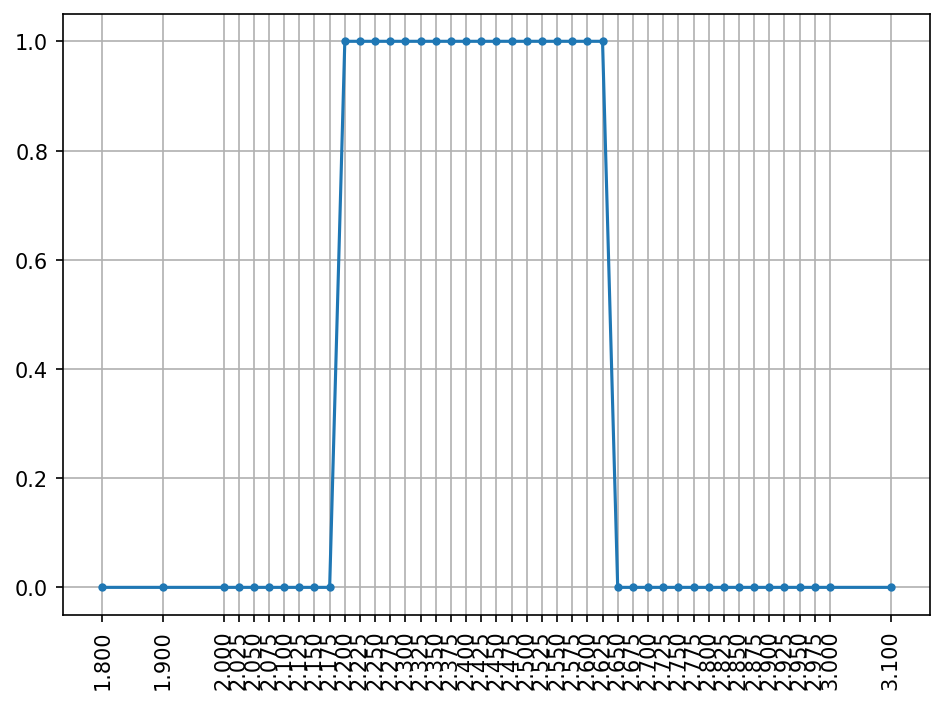

In [8]:
print(f5['arrs'].shape)
import matplotlib.pyplot as plt 

plt.figure(dpi=150)
plt.plot(Ts_G_0[8:-9],labels_tmp[8:-9],'.-')
# plt.plot(labels_train)
plt.xticks(Ts_G_0[8:-9],rotation=90)
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
#Alternative labels (do not run this module if you do not need it)

# factor=0.3
# cut=np.amax(xiBs)*factor
# labels_tmp=((Ts[Targs] <= 2.5) & (Ts[Targs]>=2.10)).astype(np.float32) # Arbitrty region
# #labels_tmp=np.heaviside(xiBs[Targs]-cut,1.0) # Cut region

# labels_train=np.repeat(labels_tmp,8000)
# labels_validate=np.repeat(labels_tmp,2000)
# T0,T1=Ts[np.where(labels_tmp==1.0)[0][[0,-1]]]

# plt.plot(Ts[Targs],labels_tmp)
# T0,T1

In [10]:
#h5py data read
#torch.set_default_tensor_type('torch.cuda.FloatTensor') # Remove this if not using cuda
data_train=f5['arrs'][Targs,:8000,:]
data_validate=f5['arrs'][Targs,8000:,:]
#labels_train=np.heaviside(xiBs[Targs]-cut,1.0)

data_train=data_train.reshape(Targs.shape[0]*8000,1600)


# --------------------------Edited by Dileep ------------------------------------------
data_validate_new=f5_new['arrs'][Targs,8000:,:]
data_validate_new2=f5_new_2['arrs'][Targs,8000:,:]
data_validate_new3=f5_new_3['arrs'][Targs_new,8000:,:]
data_validate_new4=f5_new_4['arrs'][Targs,8000:,:]
# -------------------------------------------------------------------------------------
labels_train=np.repeat(labels_tmp,8000)
labels_validate=np.repeat(labels_tmp,2000)

data_train=torch.tensor(data_train)
labels_train=torch.tensor(labels_train,requires_grad=False)
labels_validate=torch.tensor(labels_validate,requires_grad=False)

In [11]:
# Creating the Network:

inner_dim=128
class VDNN(nn.Module):                           # nn.Module is a subclass from which we inherit
    def __init__(self,nl=6):                                     # Here you define the structure
        super(VDNN, self).__init__()
        layers=[]
        layers.append(nn.Linear(40*40, inner_dim))
        layers.append(nn.ReLU())
        for ln in range(nl-1):
            layers.append(nn.Linear(inner_dim, inner_dim))
            layers.append(nn.ReLU())
        layers.extend((nn.Linear(inner_dim,1), nn.Sigmoid()))
        self.layers = nn.Sequential(*layers)
    def forward(self,x):
        return self.layers(x)

class VDNN_one(nn.Module):                           # nn.Module is a subclass from which we inherit
    def __init__(self,nl=1):                                     # Here you define the structure
        super(VDNN_one, self).__init__()
        layers=[]
        layers.append(nn.Linear(40*40, inner_dim))
        layers.append(nn.ReLU())
        for ln in range(nl-1):
            layers.append(nn.Linear(inner_dim, inner_dim))
            layers.append(nn.ReLU())
        layers.extend((nn.Linear(inner_dim,1), nn.Sigmoid()))
        self.layers = nn.Sequential(*layers)
    def forward(self,x):
        return self.layers(x)

    

class SimpleNet(nn.Module):                           # nn.Module is a subclass from which we inherit
    def __init__(self,nl=2):                                     # Here you define the structure
        super(SimpleNet, self).__init__()
        layers=[]
        layers.extend((nn.Linear(1,inner_dim), nn.ReLU(), nn.Linear(inner_dim,1), nn.Sigmoid()))
        self.layers = nn.Sequential(*layers)
    def forward(self,x):
        return self.layers(x)
class VCNN(nn.Module): # A CNN based classifier
    def __init__(self):
        super(VCNN, self).__init__()
        self.cnn=m = nn.Sequential(nn.Conv2d(1,4, kernel_size=3, stride=1,padding_mode='circular'),
                  nn.BatchNorm2d(4),
                  nn.ReLU(),
                  nn.MaxPool2d(3, stride=2),
                  nn.Conv2d(4,4, kernel_size=3, stride=1,padding_mode='circular'),
                  nn.BatchNorm2d(4),
                  nn.ReLU(),
                  nn.MaxPool2d(3, stride=2)) # last outs (-1,4,7,7)
        self.classifier=nn.Sequential(nn.Linear(4*7*7,1),nn.Sigmoid())
        
    def forward(self,x):
        x=x.view(-1,40,40)
        x=x.view(-1,1,40,40) # Extra channel for CNN
        x=self.cnn(x)
        x=x.view(-1,4*7*7) # Reducing the dimension 
        x=self.classifier(x)
        return x

In [12]:
#Define NN and training parameters

depth=4
net=VDNN(depth)
loss_fn = nn.BCELoss(reduction='none')
count=0

#-------------------------------------------
#No of epochs during training
optim_step=500
#-------------------------------------------

losses=[]

NN_test=Targs.shape[0]*8000

model_type=type(net).__name__

In [13]:
#scheduler
lr=5e-6

optimizer = optim.Adam(net.parameters(),lr=lr,weight_decay=0)
scheduler = ReduceLROnPlateau(optimizer,"min",patience=5)
from collections import deque
osfnames=deque()

In [17]:
%%time
#------------Loss variable for each iteration-----------
Loss_epoch = []
#Loss_batch = 0
#------------
#training
net.train()
batch_size=150
is_theta=True
is_ab=False
is_shuffling=False
batch_no=np.int32(NN_test/batch_size)

shuffle_injection_frequency=50
while (count<optim_step):
    Loss_batch = 0 #for loss plot
    optimizer.zero_grad()
    NNs=torch.randperm(NN_test)
    for k in np.arange(batch_no):
        optimizer.zero_grad()
        inds = NNs[k*batch_size:(k+1)*batch_size]
        inds = inds[:batch_size]
        datas2 = data_train[inds]
        labels2 = labels_train[inds]
        
        sgn=(2*torch.bernoulli(torch.ones(batch_size)*0.5)-1).unsqueeze(-1)
        dt=datas2
        dt=dt*sgn
    # Adversarial 
        if is_ab:
            a,b=torch.rand(2,batch_size)
            a=0.25+2*torch.unsqueeze(a,-1)
            b=1*(torch.unsqueeze(b,-1)-0.5)
            #a,b=1,0 #no a,b
            dt=(dt*a)
            sgn=(2*torch.bernoulli(torch.ones(batch_size)*0.5)-1).unsqueeze(-1)
            dt=(dt*sgn)+b
   
    #shuffling
        if is_shuffling:
            s_inds=torch.randperm(1600)
            dt[:shuffle_injection_frequency,:]=dt[:shuffle_injection_frequency,s_inds]
            labels2[:shuffle_injection_frequency]=0
    
        #A random shift x and y
        i,j=torch.randint(40,[2])
        dt2=dt.reshape(batch_size,40,40)
        dt=torch.roll(dt2,[i,j],dims=[1,2]).reshape(batch_size,1600)

        #Training
        poutputs=net(dt)
        targets=labels2

        with torch.no_grad():
            w1=0.5
            wghts=(w1*targets+(1-w1)*(1-targets))
            wghts=wghts/torch.sum(wghts)
        loss_tmp=loss_fn(poutputs,torch.unsqueeze(targets,1))
        loss=torch.sum(loss_tmp.squeeze(1)*wghts)
        loss.backward()
        if k%1000==0:
            losses.append(loss.detach().cpu())
            with torch.no_grad():
                d=torch.tensor(data_validate.reshape(61*2000,1600))
                output_v=net(d)
                labels_v=torch.tensor(labels_validate)
                loss_v=loss_fn(output_v,labels_v.unsqueeze(-1))
                loss_v=torch.mean(loss_v)
            print(count,k,loss.detach().cpu(),loss_v.detach().cpu(),end='\n')
        optimizer.step()
        #------averaging loss-------
        Loss_batch += loss.detach().cpu().item()
    
    Loss_batch /= batch_no     
    scheduler.step(Loss_batch)
    Loss_epoch.append(Loss_batch)
    
    if count%1==0 and count>0: #Saving last five models 
        sfname="./trained_%s_%d_D_%d_%.0f"%(model_type,count,depth,100*factor)
        if is_theta:
            sfname=sfname+"_theta"
        else:
            sfname=sfname+"full_curve"
        if is_ab:
            sfname=sfname+"_ab"
        if is_shuffling:
            sfname=sfname+"_shuffling"
        sfname=sfname+".dat"
        
        if len(osfnames)>5:
            osfname=osfnames.popleft()
            if os.path.exists(osfname):
                print("Removing:%s"%osfname)
                os.remove(osfname)
            
        with open(sfname,"wb") as fl:
            print(sfname)
            pickle.dump(net.state_dict(),fl)
            pickle.dump({'T0':T0,'T1':T1,'Targs':Targs,'epochs':count,'losses':losses,'batch_size': batch_size, 'epoch_size': NN_test},fl)
            osfnames.append(sfname)
            fl.close()
    count=count+1

<timed exec>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).


1 0 tensor(0.2439) tensor(0.3178)
1 1000 tensor(0.2435) tensor(0.3099)
1 2000 tensor(0.3480) tensor(0.3025)
1 3000 tensor(0.2635) tensor(0.3002)
./trained_VDNN_1_D_4_30_theta.dat
2 0 tensor(0.2264) tensor(0.3008)
2 1000 tensor(0.3220) tensor(0.2942)
2 2000 tensor(0.2235) tensor(0.2930)
2 3000 tensor(0.3179) tensor(0.2939)
./trained_VDNN_2_D_4_30_theta.dat
3 0 tensor(0.3561) tensor(0.2889)
3 1000 tensor(0.3024) tensor(0.2850)
3 2000 tensor(0.2561) tensor(0.2824)
3 3000 tensor(0.3453) tensor(0.2813)
./trained_VDNN_3_D_4_30_theta.dat
4 0 tensor(0.3176) tensor(0.2812)
4 1000 tensor(0.2462) tensor(0.2794)
4 2000 tensor(0.2117) tensor(0.2804)
4 3000 tensor(0.3281) tensor(0.2765)
./trained_VDNN_4_D_4_30_theta.dat
5 0 tensor(0.2277) tensor(0.2765)
5 1000 tensor(0.3454) tensor(0.2760)
5 2000 tensor(0.2764) tensor(0.2719)
5 3000 tensor(0.3217) tensor(0.2731)
./trained_VDNN_5_D_4_30_theta.dat
6 0 tensor(0.2966) tensor(0.2739)
6 1000 tensor(0.2229) tensor(0.2684)
6 2000 tensor(0.2647) tensor(0.272

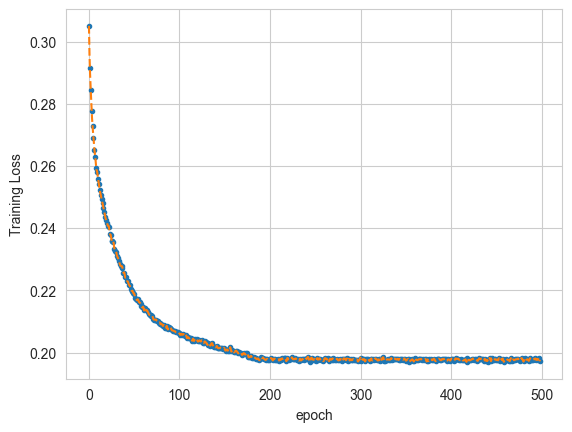

In [18]:
import scipy
sns.set_style("whitegrid")
plt.figure
plt.plot(Loss_epoch,".")
plt.ylabel("Training Loss")
plt.xlabel("epoch")
x_val=np.linspace(0,np.size(Loss_epoch)-1,np.size(Loss_epoch))
y_val=Loss_epoch
int_fnc = scipy.interpolate.make_interp_spline(x_val,y_val)
x_new = np.linspace(0,np.size(Loss_epoch)-1, np.size(Loss_epoch)*10)
y_new = int_fnc(x_new)
plt.plot(x_new,y_new,"--")
plt.show()

## G=0 Testing 

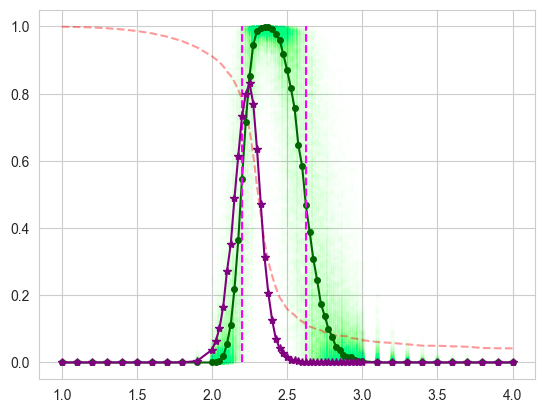

In [19]:
#Plot the output
outputs=[]
outputs_01=[]
outputs2=[]
net.eval()
with torch.no_grad():
    for i in torch.arange(Targs.shape[0]):
        d=data_validate[i,:,:]
        output=net(torch.tensor(d,dtype=torch.float32))
        output_01=(output>0.5)
        outputs_01.append(output_01.squeeze().detach().cpu().numpy())
        shfl=np.random.permutation(np.arange(1600))
        output2=net(torch.tensor(d[:,shfl],dtype=torch.float32))
        outputs.append(output.squeeze().detach().cpu().numpy())
        outputs2.append(output2.squeeze().detach().cpu().numpy())
    
#plt.plot(outputs.squeeze(),"o",alpha=0.02,color='red')
#plt.plot(labels_validate)
#depth=6
sns.set_style("whitegrid")
mu=np.average(np.fabs(np.average(data_validate[:,:2000,:],axis=2)),axis=1)
outputs=np.array(outputs)
outputs2=np.array(outputs2)
Tsn=Ts_G_0[Targs]
ax=plt.axes()

ax.scatter(np.repeat(Tsn,2000),np.concatenate(outputs),alpha=0.002,s=8.0,color='springgreen')

#plt.plot(Tsn,labels_tmp,"g.--")
ax.plot(Tsn,mu,"r--",alpha=0.4,label="\mu")
#plt.plot(Tsn,np.average(outputs,axis=1),"o-",markersize=4,color='darkgreen')
ax.plot(Tsn,np.average(outputs_01,axis=1),"o-",markersize=4,color='darkgreen',label='Model output')
T0,T1=Tsn[np.where(labels_tmp==1.0)[0][[0,-1]]]
ax.vlines(T0,0,1,color='magenta',linestyle='dashed')
ax.vlines(T1,0,1,color='magenta',linestyle='dashed')
ax.plot(Tsn,np.average(outputs2,axis=1),"*-",color='purple',label='Model output shuffled')
#plt.plot(Ts,probs)
# ax.plot(Tc,mu_avc,"r",alpha=0.4) # Ask Pallab - what is mu_avc

#plt.legend(loc="upper right")/
handles, labels = ax.get_legend_handles_labels()
plt.savefig("%s_testdata_g0.pdf"%(sfname[:-4]),dpi=300)

In [23]:
# -----------------Dileep's modification ---------------------
# Just to save the data for plotting later figures
df_adversarial_G_0 = pd.DataFrame()
df_adversarial_G_0["Ts"] = Ts_G_0
df_adversarial_G_0["mu"] = mu
df_adversarial_G_0["ordinary_data_avg_pred"] = np.average(outputs_01,axis=1)
df_adversarial_G_0["shuffled_data_avg_pred"] = np.average(outputs2,axis=1)


G_0_adversarial_scatter_plot_info_dict = {"T0":T0,"T1":T1,"Ts":np.repeat(Tsn,2000),"outputs":np.concatenate(outputs)}
# --------------------------------------------------------------

## G = 0.1 Testing

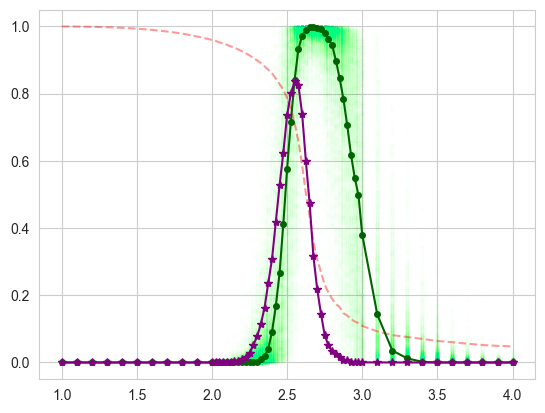

In [24]:
#---------------------------Critical region for G=0.1 ------------------
#xiBs,labels
xiBs=f5_new['xiBs'][:]
factor=0.30
cut=np.amax(xiBs)*factor

labels_tmp=np.heaviside(xiBs[Targs]-cut,1.0)
labels_train=np.repeat(labels_tmp,8000)
labels_validate=np.repeat(labels_tmp,2000)

T0,T1=Ts_G_0_1[np.where(labels_tmp==1.0)[0][[0,-1]]]
#---------------------

#Plot the output
outputs=[]
outputs_01=[]
outputs2=[]
net.eval()
with torch.no_grad():
    for i in torch.arange(Targs.shape[0]):
        d=data_validate_new[i,:,:]
        output=net(torch.tensor(d,dtype=torch.float32))
        output_01=(output>0.5)
        outputs_01.append(output_01.squeeze().detach().cpu().numpy())
        shfl=np.random.permutation(np.arange(1600))
        output2=net(torch.tensor(d[:,shfl],dtype=torch.float32))
        outputs.append(output.squeeze().detach().cpu().numpy())
        outputs2.append(output2.squeeze().detach().cpu().numpy())
    
#plt.plot(outputs.squeeze(),"o",alpha=0.02,color='red')
#plt.plot(labels_validate)
#depth=6
sns.set_style("whitegrid")
mu=np.average(np.fabs(np.average(data_validate_new[:,:2000,:],axis=2)),axis=1)
outputs=np.array(outputs)
outputs2=np.array(outputs2)
Tsn=Ts_G_0_1[Targs]
ax=plt.axes()

ax.scatter(np.repeat(Tsn,2000),np.concatenate(outputs),alpha=0.002,s=8.0,color='springgreen')

#plt.plot(Tsn,labels_tmp,"g.--")
ax.plot(Tsn,mu,"r--",alpha=0.4,label="\mu")
#plt.plot(Tsn,np.average(outputs,axis=1),"o-",markersize=4,color='darkgreen')
ax.plot(Tsn,np.average(outputs_01,axis=1),"o-",markersize=4,color='darkgreen',label='Model output')
T0,T1=Tsn[np.where(labels_tmp==1.0)[0][[0,-1]]]
# ax.vlines(T0,0,1,color='magenta',linestyle='dashed')
# ax.vlines(T1,0,1,color='magenta',linestyle='dashed')
ax.plot(Tsn,np.average(outputs2,axis=1),"*-",color='purple',label='Model output shuffled')
#plt.plot(Ts,probs)
# ax.plot(Tc,mu_avc,"r",alpha=0.4) # Ask Pallab - what is mu_avc

#plt.legend(loc="upper right")/
handles, labels = ax.get_legend_handles_labels()
plt.savefig("%s_testdata_g0.pdf"%(sfname[:-4]),dpi=300)

In [25]:
# -----------------Dileep's modification ---------------------
# Just to save the data for plotting later figures
df_adversarial_G_0_1 = pd.DataFrame()
df_adversarial_G_0_1["Ts"] = Ts_G_0_1
df_adversarial_G_0_1["mu"] = mu
df_adversarial_G_0_1["ordinary_data_avg_pred"] = np.average(outputs_01,axis=1)
df_adversarial_G_0_1["shuffled_data_avg_pred"] = np.average(outputs2,axis=1)


G_0_1_adversarial_scatter_plot_info_dict = {"T0":T0,"T1":T1,"Ts":np.repeat(Tsn,2000),"outputs":np.concatenate(outputs)}
# --------------------------------------------------------------

# G = 0.5 Testing 

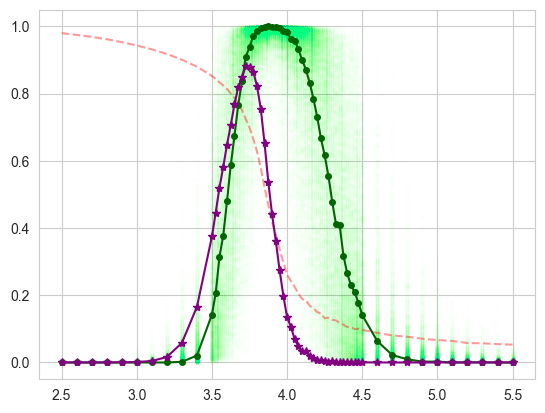

In [26]:
#---------------------------Critical region for G=0.5 ------------------
#xiBs,labels
xiBs=f5_new_2['xiBs'][:]
factor=0.30
cut=np.amax(xiBs)*factor

labels_tmp=np.heaviside(xiBs[Targs]-cut,1.0)
labels_train=np.repeat(labels_tmp,8000)
labels_validate=np.repeat(labels_tmp,2000)

T0,T1=Ts_G_0_5[np.where(labels_tmp==1.0)[0][[0,-1]]]
#---------------------


#Plot the output
outputs=[]
outputs_01=[]
outputs2=[]
net.eval()
with torch.no_grad():
    for i in torch.arange(Targs.shape[0]):
        d=data_validate_new2[i,:,:]
        output=net(torch.tensor(d,dtype=torch.float32))
        output_01=(output>0.5)
        outputs_01.append(output_01.squeeze().detach().numpy())
        shfl=np.random.permutation(np.arange(1600))
        output2=net(torch.tensor(d[:,shfl],dtype=torch.float32))
        outputs.append(output.squeeze().detach().numpy())
        outputs2.append(output2.squeeze().detach().numpy())
    
#plt.plot(outputs.squeeze(),"o",alpha=0.02,color='red')
#plt.plot(labels_validate)
#depth=6
sns.set_style("whitegrid")
mu=np.average(np.fabs(np.average(data_validate_new2[:,:2000,:],axis=2)),axis=1)
outputs=np.array(outputs)
outputs2=np.array(outputs2)
Tsn=Ts_G_0_5[Targs]
ax=plt.axes()

ax.scatter(np.repeat(Tsn,2000),np.concatenate(outputs),alpha=0.002,s=8.0,color='springgreen')

#plt.plot(Tsn,labels_tmp,"g.--")
ax.plot(Tsn,mu,"r--",alpha=0.4,label="\mu")
#plt.plot(Tsn,np.average(outputs,axis=1),"o-",markersize=4,color='darkgreen')
ax.plot(Tsn,np.average(outputs_01,axis=1),"o-",markersize=4,color='darkgreen',label='Model output')
T0,T1=Tsn[np.where(labels_tmp==1.0)[0][[0,-1]]]
# ax.vlines(T0,0,1,color='magenta',linestyle='dashed')
# ax.vlines(T1,0,1,color='magenta',linestyle='dashed')
ax.plot(Tsn,np.average(outputs2,axis=1),"*-",color='purple',label='Model output shuffled')
#plt.plot(Ts,probs)
# ax.plot(Tc,mu_avc,"r",alpha=0.4) # Ask Pallab - what is mu_avc

#plt.legend(loc="upper right")/
handles, labels = ax.get_legend_handles_labels()
plt.savefig("%s_testdata_g0.pdf"%(sfname[:-4]),dpi=300)

In [27]:
# -----------------Dileep's modification ---------------------
# Just to save the data for plotting later figures
df_adversarial_G_0_5 = pd.DataFrame()
df_adversarial_G_0_5["Ts"] = Ts_G_0_5
df_adversarial_G_0_5["mu"] = mu
df_adversarial_G_0_5["ordinary_data_avg_pred"] = np.average(outputs_01,axis=1)
df_adversarial_G_0_5["shuffled_data_avg_pred"] = np.average(outputs2,axis=1)


G_0_5_adversarial_scatter_plot_info_dict = {"T0":T0,"T1":T1,"Ts":np.repeat(Tsn,2000),"outputs":np.concatenate(outputs)}
# ------------------------------------------------------------

## G=1, J=1 testing

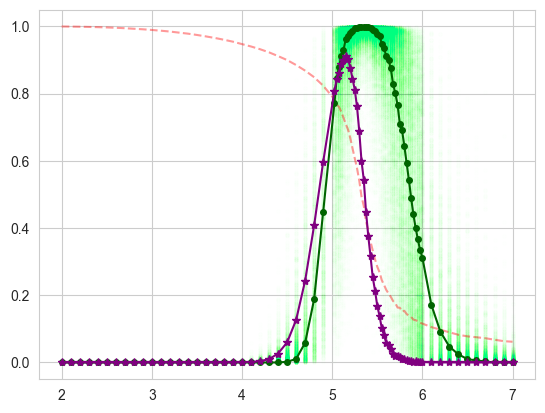

In [28]:
#---------------------------Critical region for G=0.5 ------------------
#xiBs,labels
xiBs=f5_new_3['xiBs'][:]
factor=0.30
cut=np.amax(xiBs)*factor

labels_tmp=np.heaviside(xiBs[Targs_new]-cut,1.0)
labels_train=np.repeat(labels_tmp,8000)
labels_validate=np.repeat(labels_tmp,2000)

T0,T1=Ts_G_1[np.where(labels_tmp==1.0)[0][[0,-1]]]
#---------------------


#Plot the output
outputs=[]
outputs_01=[]
outputs2=[]
net.eval()
with torch.no_grad():
    for i in torch.arange(Targs_new.shape[0]):
        d=data_validate_new3[i,:,:]
        output=net(torch.tensor(d,dtype=torch.float32))
        output_01=(output>0.5)
        outputs_01.append(output_01.squeeze().detach().numpy())
        shfl=np.random.permutation(np.arange(1600))
        output2=net(torch.tensor(d[:,shfl],dtype=torch.float32))
        outputs.append(output.squeeze().detach().numpy())
        outputs2.append(output2.squeeze().detach().numpy())
    
#plt.plot(outputs.squeeze(),"o",alpha=0.02,color='red')
#plt.plot(labels_validate)
#depth=6
sns.set_style("whitegrid")
mu=np.average(np.fabs(np.average(data_validate_new3[:,:2000,:],axis=2)),axis=1)
outputs=np.array(outputs)
outputs2=np.array(outputs2)
Tsn=Ts_G_1[Targs_new]
ax=plt.axes()

ax.scatter(np.repeat(Tsn,2000),np.concatenate(outputs),alpha=0.002,s=8.0,color='springgreen')

#plt.plot(Tsn,labels_tmp,"g.--")
ax.plot(Tsn,mu,"r--",alpha=0.4,label="\mu")
#plt.plot(Tsn,np.average(outputs,axis=1),"o-",markersize=4,color='darkgreen')
ax.plot(Tsn,np.average(outputs_01,axis=1),"o-",markersize=4,color='darkgreen',label='Model output')
T0,T1=Tsn[np.where(labels_tmp==1.0)[0][[0,-1]]]
# ax.vlines(T0,0,1,color='magenta',linestyle='dashed')
# ax.vlines(T1,0,1,color='magenta',linestyle='dashed')
ax.plot(Tsn,np.average(outputs2,axis=1),"*-",color='purple',label='Model output shuffled')
#plt.plot(Ts,probs)
# ax.plot(Tc,mu_avc,"r",alpha=0.4) # Ask Pallab - what is mu_avc

#plt.legend(loc="upper right")/
handles, labels = ax.get_legend_handles_labels()
plt.savefig("%s_testdata_g0.pdf"%(sfname[:-4]),dpi=300)

## J=0.01, G=1 testing

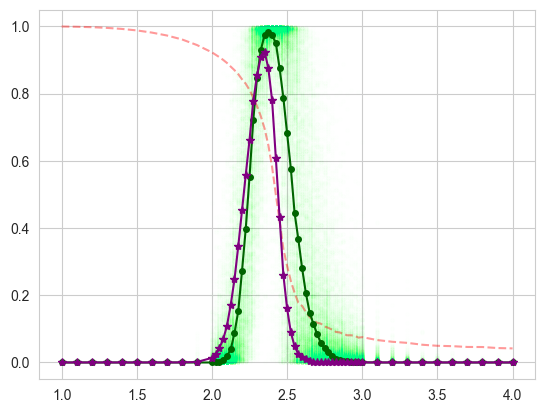

In [29]:
#---------------------------Critical region for G=0.5 ------------------
#xiBs,labels
xiBs=f5_new_4['xiBs'][:]
factor=0.30
cut=np.amax(xiBs)*factor

labels_tmp=np.heaviside(xiBs[Targs]-cut,1.0)
labels_train=np.repeat(labels_tmp,8000)
labels_validate=np.repeat(labels_tmp,2000)

T0,T1=Ts_G_1_J_0[np.where(labels_tmp==1.0)[0][[0,-1]]]
#---------------------


#Plot the output
outputs=[]
outputs_01=[]
outputs2=[]
net.eval()
with torch.no_grad():
    for i in torch.arange(Targs.shape[0]):
        d=data_validate_new4[i,:,:]
        output=net(torch.tensor(d,dtype=torch.float32))
        output_01=(output>0.5)
        outputs_01.append(output_01.squeeze().detach().numpy())
        shfl=np.random.permutation(np.arange(1600))
        output2=net(torch.tensor(d[:,shfl],dtype=torch.float32))
        outputs.append(output.squeeze().detach().numpy())
        outputs2.append(output2.squeeze().detach().numpy())
    
#plt.plot(outputs.squeeze(),"o",alpha=0.02,color='red')
#plt.plot(labels_validate)
#depth=6
sns.set_style("whitegrid")
mu=np.average(np.fabs(np.average(data_validate_new4[:,:2000,:],axis=2)),axis=1)
outputs=np.array(outputs)
outputs2=np.array(outputs2)
Tsn=Ts_G_1_J_0[Targs]
ax=plt.axes()

ax.scatter(np.repeat(Tsn,2000),np.concatenate(outputs),alpha=0.002,s=8.0,color='springgreen')

#plt.plot(Tsn,labels_tmp,"g.--")
ax.plot(Tsn,mu,"r--",alpha=0.4,label="\mu")
#plt.plot(Tsn,np.average(outputs,axis=1),"o-",markersize=4,color='darkgreen')
ax.plot(Tsn,np.average(outputs_01,axis=1),"o-",markersize=4,color='darkgreen',label='Model output')
T0,T1=Tsn[np.where(labels_tmp==1.0)[0][[0,-1]]]
# ax.vlines(T0,0,1,color='magenta',linestyle='dashed')
# ax.vlines(T1,0,1,color='magenta',linestyle='dashed')
ax.plot(Tsn,np.average(outputs2,axis=1),"*-",color='purple',label='Model output shuffled')
#plt.plot(Ts,probs)
# ax.plot(Tc,mu_avc,"r",alpha=0.4) # Ask Pallab - what is mu_avc

#plt.legend(loc="upper right")/
handles, labels = ax.get_legend_handles_labels()
plt.savefig("%s_testdata_g0.pdf"%(sfname[:-4]),dpi=300)

# <span style="color:green"> Dileep's modifications</span>

## Training With out shuffling

In [30]:
#Define NN and training parameters
depth=4
net_ordinary=VDNN(depth)
loss_fn = nn.BCELoss(reduction='none')
count=0

# #-------------------------------------------
# #No of epochs during training
# optim_step=15
# #--------------------------------------------------------------------------------
# Commented out because this parameter is defined during the previous training 
#----------------------------------------------------------------------------------


losses=[]

NN_test=Targs.shape[0]*8000

model_type=type(net).__name__

In [31]:
#scheduler
lr=5e-6


optimizer = optim.Adam(net_ordinary.parameters(),lr=lr,weight_decay=0)
scheduler = ReduceLROnPlateau(optimizer, "min", patience=5)
from collections import deque
osfnames=deque()

In [32]:
%%time

#------------Loss variable for each iteration-----------
Loss_epoch = []
#Loss_batch = 0
#------------

#training
net_ordinary.train()
batch_size=150
is_theta=True
is_ab=False
is_shuffling=False
batch_no=np.int32(NN_test/batch_size)

shuffle_injection_frequency=50
while (count<optim_step):
    Loss_batch = 0 #for loss plot
    optimizer.zero_grad()
    NNs=torch.randperm(NN_test)
    for k in np.arange(batch_no):
        optimizer.zero_grad()
        inds = NNs[k*batch_size:(k+1)*batch_size]
        inds = inds[:batch_size]
        datas2 = data_train[inds]
        labels2 = labels_train[inds]
        
        sgn=(2*torch.bernoulli(torch.ones(batch_size)*0.5)-1).unsqueeze(-1)
        dt=torch.tensor(datas2,dtype=torch.float32)
        dt=dt*sgn
    # Adversarial 
        if is_ab:
            a,b=torch.rand(2,batch_size)
            a=0.25+2*torch.unsqueeze(a,-1)
            b=1*(torch.unsqueeze(b,-1)-0.5)
            #a,b=1,0 #no a,b
            dt=(dt*a)
            sgn=(2*torch.bernoulli(torch.ones(batch_size)*0.5)-1).unsqueeze(-1)
            dt=(dt*sgn)+b
   
    #shuffling
        if is_shuffling:
            s_inds=torch.randperm(1600)
            dt[:shuffle_injection_frequency,:]=dt[:shuffle_injection_frequency,s_inds]
            labels2[:shuffle_injection_frequency]=0
    
        #A random shift x and y
        i,j=torch.randint(40,[2])
        dt2=dt.reshape(batch_size,40,40)
        dt=torch.roll(dt2,[i,j],dims=[1,2]).reshape(batch_size,1600)

        #Training
        poutputs=net_ordinary(dt)
        targets=torch.tensor(labels2,dtype=torch.float32,requires_grad=False)

        with torch.no_grad():
            w1=0.5
            wghts=(w1*targets+(1-w1)*(1-targets))
            wghts=wghts/torch.sum(wghts)
        loss_tmp=loss_fn(poutputs,torch.unsqueeze(targets,1))
        loss=torch.sum(loss_tmp.squeeze(1)*wghts)
        loss.backward()
        if k%1000==0:
            losses.append(loss.detach().cpu())
            with torch.no_grad():
                d=torch.tensor(data_validate.reshape(61*2000,1600))
                output_v=net_ordinary(d)
                labels_v=torch.tensor(labels_validate)
                loss_v=loss_fn(output_v,labels_v.unsqueeze(-1))
                loss_v=torch.mean(loss_v)
            print(count,k,loss.detach().cpu(),loss_v.detach().cpu(),end='\n')
        optimizer.step()
        #------averaging loss-------
        Loss_batch += loss.detach().cpu().item()
    
    Loss_batch /= batch_no     
    scheduler.step(Loss_batch)
    Loss_epoch.append(Loss_batch)
        
        
    if count%1==0 and count>0: #Saving last five models 
        sfname="./trained_%s_%d_D_%d_%.0f"%(model_type,count,depth,100*factor)
        if is_theta:
            sfname=sfname+"_theta"
        else:
            sfname=sfname+"full_curve"
        if is_ab:
            sfname=sfname+"_ab"
        if is_shuffling:
            sfname=sfname+"_shuffling"
        sfname=sfname+".dat"
        
        if len(osfnames)>5:
            osfname=osfnames.popleft()
            if os.path.exists(osfname):
                print("Removing:%s"%osfname)
                os.remove(osfname)
            
        with open(sfname,"wb") as fl:
            print(sfname)
            pickle.dump(net_ordinary.state_dict(),fl)
            pickle.dump({'T0':T0,'T1':T1,'Targs':Targs,'epochs':count,'losses':losses,'batch_size': batch_size, 'epoch_size': NN_test},fl)
            osfnames.append(sfname)
            fl.close()
    count=count+1

<timed exec>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).


0 0 tensor(0.6887) tensor(0.6886)
0 1000 tensor(0.5289) tensor(0.5107)
0 2000 tensor(0.5668) tensor(0.4962)
0 3000 tensor(0.5109) tensor(0.4767)
1 0 tensor(0.4979) tensor(0.4717)
1 1000 tensor(0.4513) tensor(0.4570)
1 2000 tensor(0.4282) tensor(0.4443)
1 3000 tensor(0.4426) tensor(0.4297)
./trained_VDNN_1_D_4_30_theta.dat
2 0 tensor(0.4313) tensor(0.4257)
2 1000 tensor(0.4632) tensor(0.4088)
2 2000 tensor(0.4103) tensor(0.3933)
2 3000 tensor(0.4595) tensor(0.3814)
./trained_VDNN_2_D_4_30_theta.dat
3 0 tensor(0.3290) tensor(0.3788)
3 1000 tensor(0.3579) tensor(0.3704)
3 2000 tensor(0.3395) tensor(0.3633)
3 3000 tensor(0.3229) tensor(0.3572)
./trained_VDNN_3_D_4_30_theta.dat
4 0 tensor(0.3053) tensor(0.3558)
4 1000 tensor(0.2755) tensor(0.3509)
4 2000 tensor(0.3325) tensor(0.3463)
4 3000 tensor(0.3483) tensor(0.3424)
./trained_VDNN_4_D_4_30_theta.dat
5 0 tensor(0.3581) tensor(0.3413)
5 1000 tensor(0.3864) tensor(0.3378)
5 2000 tensor(0.2984) tensor(0.3343)
5 3000 tensor(0.2756) tensor(0.

## G = 0.0 Testing

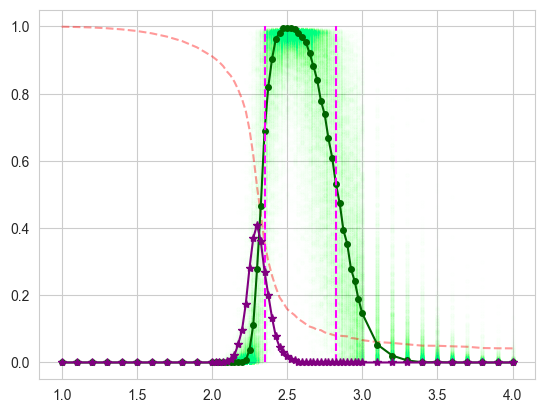

In [33]:
#Plot the output
outputs=[]
outputs_01=[]
outputs2=[]
net_ordinary.eval()
with torch.no_grad():
    for i in torch.arange(Targs.shape[0]):
        d=data_validate[i,:,:]
        output=net_ordinary(torch.tensor(d,dtype=torch.float32))
        output_01=(output>0.5)
        outputs_01.append(output_01.squeeze().detach().numpy())
        shfl=np.random.permutation(np.arange(1600))
        output2=net_ordinary(torch.tensor(d[:,shfl],dtype=torch.float32))
        outputs.append(output.squeeze().detach().numpy())
        outputs2.append(output2.squeeze().detach().numpy())
    
#plt.plot(outputs.squeeze(),"o",alpha=0.02,color='red')
#plt.plot(labels_validate)
#depth=6
sns.set_style("whitegrid")
mu=np.average(np.fabs(np.average(data_validate[:,:2000,:],axis=2)),axis=1)
outputs=np.array(outputs)
outputs2=np.array(outputs2)
Tsn=Ts_G_0[Targs]
ax=plt.axes()

ax.scatter(np.repeat(Tsn,2000),np.concatenate(outputs),alpha=0.002,s=8.0,color='springgreen')

#plt.plot(Tsn,labels_tmp,"g.--")
ax.plot(Tsn,mu,"r--",alpha=0.4,label="\mu")
#plt.plot(Tsn,np.average(outputs,axis=1),"o-",markersize=4,color='darkgreen')
ax.plot(Tsn,np.average(outputs_01,axis=1),"o-",markersize=4,color='darkgreen',label='Model output')
T0,T1=Tsn[np.where(labels_tmp==1.0)[0][[0,-1]]]
ax.vlines(T0,0,1,color='magenta',linestyle='dashed')
ax.vlines(T1,0,1,color='magenta',linestyle='dashed')
ax.plot(Tsn,np.average(outputs2,axis=1),"*-",color='purple',label='Model output shuffled')
#plt.plot(Ts,probs)
# ax.plot(Tc,mu_avc,"r",alpha=0.4) # Ask Pallab - what is mu_avc

#plt.legend(loc="upper right")/
handles, labels = ax.get_legend_handles_labels()
plt.savefig("%s_testdata_g0.pdf"%(sfname[:-4]),dpi=300)

# 

In [34]:
# -----------------Dileep's modification ---------------------
# Just to save the data for plotting later figures
df_ordinary_G_0 = pd.DataFrame()
df_ordinary_G_0["Ts"] = Ts_G_0
df_ordinary_G_0["mu"] = mu
df_ordinary_G_0["ordinary_data_avg_pred"] = np.average(outputs_01,axis=1)
df_ordinary_G_0["shuffled_data_avg_pred"] = np.average(outputs2,axis=1)
# ------------------------------------------------------------

# G = 0.1 Testing

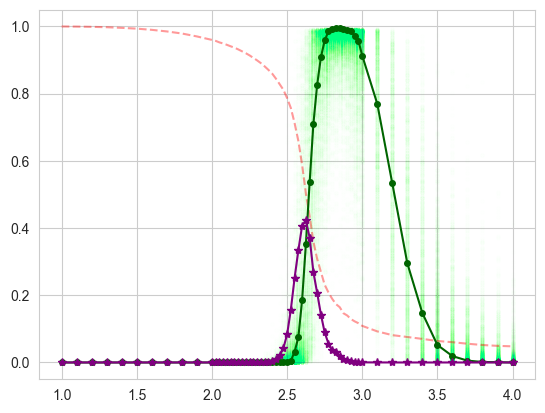

In [35]:
#Plot the output
outputs=[]
outputs_01=[]
outputs2=[]
net_ordinary.eval()
with torch.no_grad():
    for i in torch.arange(Targs.shape[0]):
        d=data_validate_new[i,:,:]
        output=net_ordinary(torch.tensor(d,dtype=torch.float32))
        output_01=(output>0.5)
        outputs_01.append(output_01.squeeze().detach().numpy())
        shfl=np.random.permutation(np.arange(1600))
        output2=net_ordinary(torch.tensor(d[:,shfl],dtype=torch.float32))
        outputs.append(output.squeeze().detach().numpy())
        outputs2.append(output2.squeeze().detach().numpy())
    
#plt.plot(outputs.squeeze(),"o",alpha=0.02,color='red')
#plt.plot(labels_validate)
#depth=6
sns.set_style("whitegrid")
mu=np.average(np.fabs(np.average(data_validate_new[:,:2000,:],axis=2)),axis=1)
outputs=np.array(outputs)
outputs2=np.array(outputs2)
Tsn=Ts_G_0_1[Targs]
ax=plt.axes()

ax.scatter(np.repeat(Tsn,2000),np.concatenate(outputs),alpha=0.002,s=8.0,color='springgreen')

#plt.plot(Tsn,labels_tmp,"g.--")
ax.plot(Tsn,mu,"r--",alpha=0.4,label="\mu")
#plt.plot(Tsn,np.average(outputs,axis=1),"o-",markersize=4,color='darkgreen')
ax.plot(Tsn,np.average(outputs_01,axis=1),"o-",markersize=4,color='darkgreen',label='Model output')
T0,T1=Tsn[np.where(labels_tmp==1.0)[0][[0,-1]]]
# ax.vlines(T0,0,1,color='magenta',linestyle='dashed')
# ax.vlines(T1,0,1,color='magenta',linestyle='dashed')
ax.plot(Tsn,np.average(outputs2,axis=1),"*-",color='purple',label='Model output shuffled')
#plt.plot(Ts,probs)
# ax.plot(Tc,mu_avc,"r",alpha=0.4) # Ask Pallab - what is mu_avc

#plt.legend(loc="upper right")/
handles, labels = ax.get_legend_handles_labels()
plt.savefig("%s_testdata_g0.pdf"%(sfname[:-4]),dpi=300)

In [36]:
# -----------------Dileep's modification ---------------------
# Just to save the data for plotting later figures
df_ordinary_G_0_1 = pd.DataFrame()
df_ordinary_G_0_1["Ts"] = Ts_G_0_1
df_ordinary_G_0_1["mu"] = mu
df_ordinary_G_0_1["ordinary_data_avg_pred"] = np.average(outputs_01,axis=1)
df_ordinary_G_0_1["shuffled_data_avg_pred"] = np.average(outputs2,axis=1)
# ------------------------------------------------------------

## G = 0.5 Testing

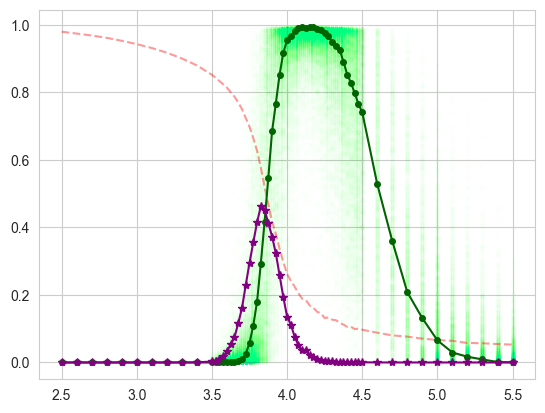

In [37]:
#Plot the output
outputs=[]
outputs_01=[]
outputs2=[]
net_ordinary.eval()
with torch.no_grad():
    for i in torch.arange(Targs.shape[0]):
        d=data_validate_new2[i,:,:]
        output=net_ordinary(torch.tensor(d,dtype=torch.float32))
        output_01=(output>0.5)
        outputs_01.append(output_01.squeeze().detach().numpy())
        shfl=np.random.permutation(np.arange(1600))
        output2=net_ordinary(torch.tensor(d[:,shfl],dtype=torch.float32))
        outputs.append(output.squeeze().detach().numpy())
        outputs2.append(output2.squeeze().detach().numpy())
    
#plt.plot(outputs.squeeze(),"o",alpha=0.02,color='red')
#plt.plot(labels_validate)
#depth=6
sns.set_style("whitegrid")
mu=np.average(np.fabs(np.average(data_validate_new2[:,:2000,:],axis=2)),axis=1)
outputs=np.array(outputs)
outputs2=np.array(outputs2)
Tsn=Ts_G_0_5[Targs]
ax=plt.axes()

ax.scatter(np.repeat(Tsn,2000),np.concatenate(outputs),alpha=0.002,s=8.0,color='springgreen')

#plt.plot(Tsn,labels_tmp,"g.--")
ax.plot(Tsn,mu,"r--",alpha=0.4,label="\mu")
#plt.plot(Tsn,np.average(outputs,axis=1),"o-",markersize=4,color='darkgreen')
ax.plot(Tsn,np.average(outputs_01,axis=1),"o-",markersize=4,color='darkgreen',label='Model output')
T0,T1=Tsn[np.where(labels_tmp==1.0)[0][[0,-1]]]
# ax.vlines(T0,0,1,color='magenta',linestyle='dashed')
# ax.vlines(T1,0,1,color='magenta',linestyle='dashed')
ax.plot(Tsn,np.average(outputs2,axis=1),"*-",color='purple',label='Model output shuffled')
#plt.plot(Ts,probs)
# ax.plot(Tc,mu_avc,"r",alpha=0.4) # Ask Pallab - what is mu_avc

#plt.legend(loc="upper right")/
handles, labels = ax.get_legend_handles_labels()
plt.savefig("%s_testdata_g0.pdf"%(sfname[:-4]),dpi=300)

In [38]:
# -----------------Dileep's modification ---------------------
# Just to save the data for plotting later figures
df_ordinary_G_0_5 = pd.DataFrame()
df_ordinary_G_0_5["Ts"] = Ts_G_0_5
df_ordinary_G_0_5["mu"] = mu
df_ordinary_G_0_5["ordinary_data_avg_pred"] = np.average(outputs_01,axis=1)
df_ordinary_G_0_5["shuffled_data_avg_pred"] = np.average(outputs2,axis=1)
# ------------------------------------------------------------

# <span style="color:green"> Final Plots</span>

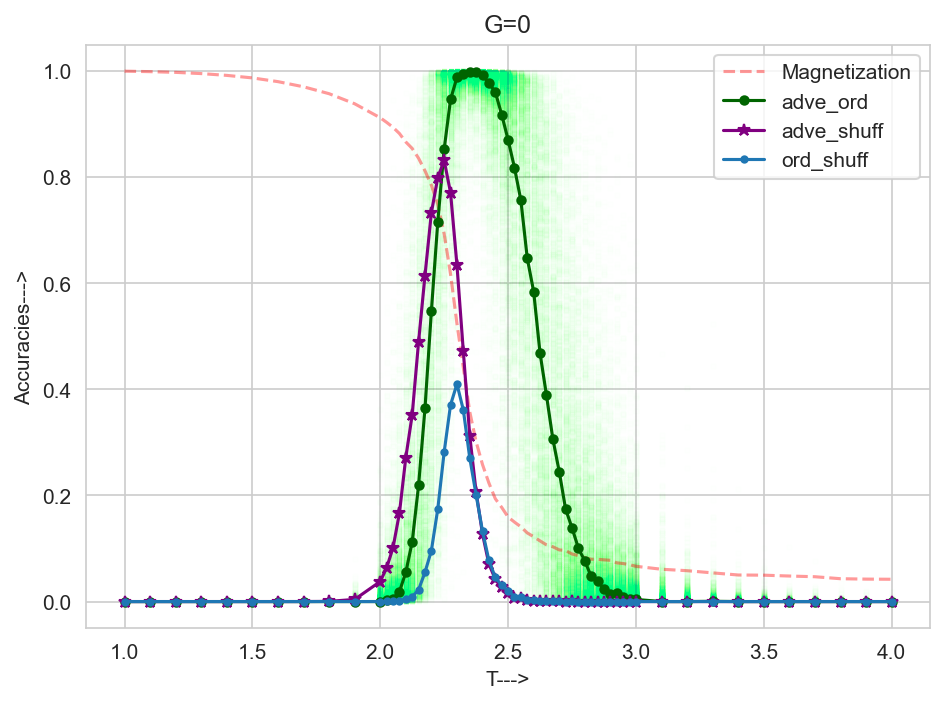

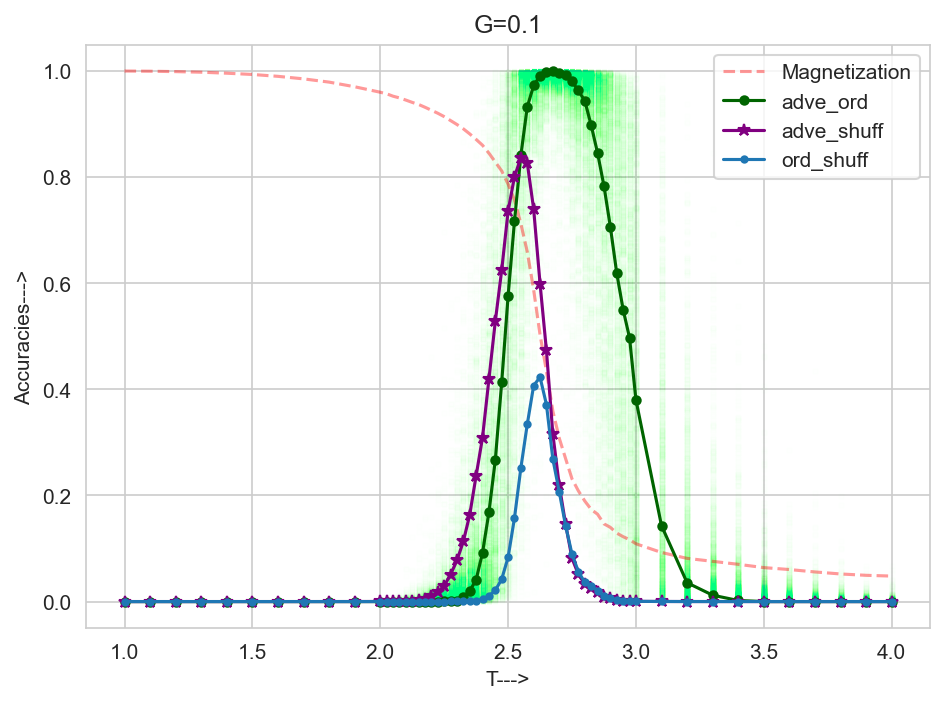

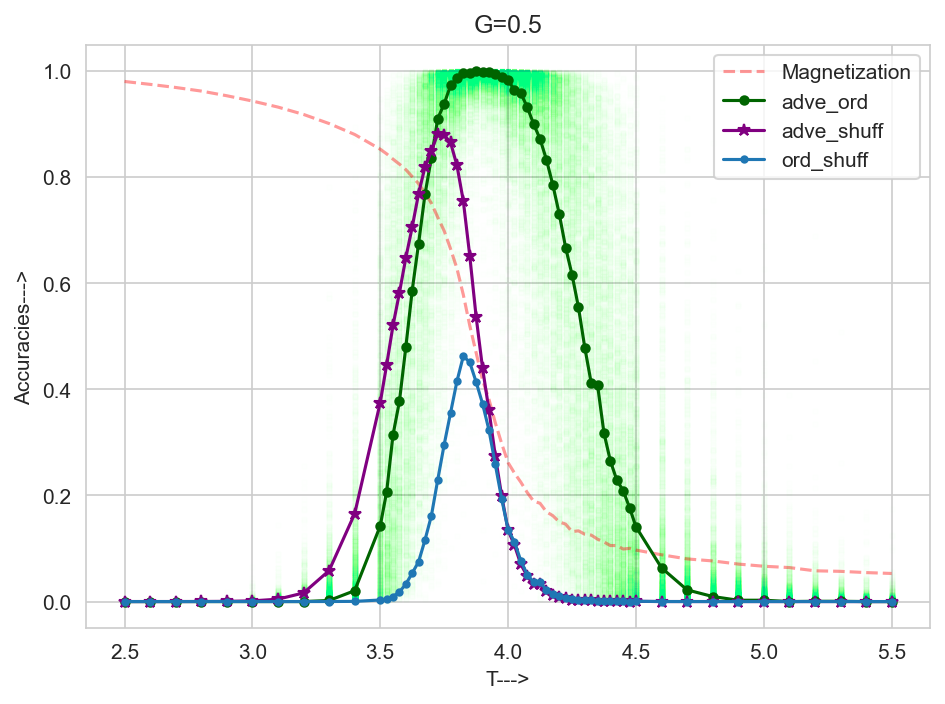

In [39]:
if not os.path.isdir("Generated_plots"):
    os.mkdir("Generated_plots")
    
    
# Ploting for G=0.0
plt.figure(dpi=150)
plt.plot(df_adversarial_G_0["Ts"], df_adversarial_G_0["mu"], "r--", alpha=0.4, label="Magnetization")
plt.plot(df_adversarial_G_0["Ts"],df_adversarial_G_0["ordinary_data_avg_pred"], "o-", markersize=4, color='darkgreen', label="adve_ord")
plt.plot(df_adversarial_G_0["Ts"],df_adversarial_G_0["shuffled_data_avg_pred"], "*-", color='purple', label="adve_shuff")
# plt.plot(df_ordinary_G_0["Ts"],df_ordinary_G_0["ordinary_data_avg_pred"],label="*****")
plt.plot(df_ordinary_G_0["Ts"],df_ordinary_G_0["shuffled_data_avg_pred"], '.-', label="ord_shuff")
# --------------------------------------------------------------------
Ts = G_0_adversarial_scatter_plot_info_dict["Ts"]
outputs = G_0_adversarial_scatter_plot_info_dict["outputs"]
T0 = G_0_adversarial_scatter_plot_info_dict["T0"]
T1 = G_0_adversarial_scatter_plot_info_dict["T1"]
plt.scatter(Ts,outputs,alpha=0.002,s=8.0,color='springgreen')
# plt.vlines(T0,0,1,color='magenta',linestyle='dashed')
# plt.vlines(T1,0,1,color='magenta',linestyle='dashed')
# --------------------------------------------------------------------
plt.xlabel("T--->")
plt.ylabel("Accuracies--->")
plt.legend()
plt.grid(True)
plt.title(f"G=0")
figure_file_name = f"G_0_accuracies_vs_T.jpg"
figure_file_path = os.path.join("Generated_plots",figure_file_name)
plt.tight_layout()
plt.savefig(figure_file_path)


# Ploting for G=0.1
plt.figure(dpi=150)
plt.plot(df_adversarial_G_0_1["Ts"],df_adversarial_G_0_1["mu"], "r--", alpha=0.4, label="Magnetization")
plt.plot(df_adversarial_G_0_1["Ts"],df_adversarial_G_0_1["ordinary_data_avg_pred"], "o-", markersize=4, color='darkgreen', label="adve_ord")
plt.plot(df_adversarial_G_0_1["Ts"],df_adversarial_G_0_1["shuffled_data_avg_pred"], "*-", color='purple', label="adve_shuff")
# plt.plot(df_ordinary_G_0_1["Ts"],df_ordinary_G_0_1["ordinary_data_avg_pred"],label="*****")
plt.plot(df_ordinary_G_0_1["Ts"],df_ordinary_G_0_1["shuffled_data_avg_pred"], '.-', label="ord_shuff")
# --------------------------------------------------------------------
Ts = G_0_1_adversarial_scatter_plot_info_dict["Ts"]
outputs = G_0_1_adversarial_scatter_plot_info_dict["outputs"]
T0 = G_0_1_adversarial_scatter_plot_info_dict["T0"]
T1 = G_0_1_adversarial_scatter_plot_info_dict["T1"]
plt.scatter(Ts,outputs,alpha=0.002,s=8.0,color='springgreen')
# plt.vlines(T0,0,1,color='magenta',linestyle='dashed')
# plt.vlines(T1,0,1,color='magenta',linestyle='dashed')
# --------------------------------------------------------------------
plt.xlabel("T--->")
plt.ylabel("Accuracies--->")
plt.legend()
plt.grid(True)
plt.title(f"G=0.1")
figure_file_name = f"G_0_1_accuracies_vs_T.jpg"
figure_file_path = os.path.join("Generated_plots",figure_file_name)
plt.tight_layout()
plt.savefig(figure_file_path)


# Ploting for G=0.5
plt.figure(dpi=150)
plt.plot(df_adversarial_G_0_5["Ts"],df_adversarial_G_0_5["mu"], "r--", alpha=0.4, label="Magnetization")
plt.plot(df_adversarial_G_0_5["Ts"],df_adversarial_G_0_5["ordinary_data_avg_pred"], "o-", markersize=4, color='darkgreen', label="adve_ord")
plt.plot(df_adversarial_G_0_5["Ts"],df_adversarial_G_0_5["shuffled_data_avg_pred"], "*-", color='purple', label="adve_shuff")
# plt.plot(df_ordinary_G_0_5["Ts"],df_ordinary_G_0_5["ordinary_data_avg_pred"],label="*****")
plt.plot(df_ordinary_G_0_5["Ts"],df_ordinary_G_0_5["shuffled_data_avg_pred"], '.-', label="ord_shuff")
# --------------------------------------------------------------------
Ts = G_0_5_adversarial_scatter_plot_info_dict["Ts"]
outputs = G_0_5_adversarial_scatter_plot_info_dict["outputs"]
T0 = G_0_5_adversarial_scatter_plot_info_dict["T0"]
T1 = G_0_5_adversarial_scatter_plot_info_dict["T1"]
plt.scatter(Ts,outputs,alpha=0.002,s=8.0,color='springgreen')
# plt.vlines(T0,0,1,color='magenta',linestyle='dashed')
# plt.vlines(T1,0,1,color='magenta',linestyle='dashed')
# --------------------------------------------------------------------
plt.xlabel("T--->")
plt.ylabel("Accuracies--->")
plt.legend()
plt.grid(True)
plt.title(f"G=0.5")
figure_file_name = f"G_0_5_accuracies_vs_T.jpg"
figure_file_path = os.path.join("Generated_plots",figure_file_name)
plt.tight_layout()
plt.savefig(figure_file_path)
